<a href="https://colab.research.google.com/github/namozhdehi/Pneumonia-/blob/main/02_Data_Wrangling_Pneumonia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 2 Data wrangling<a id='2_Data_wrangling'></a>

## 2.1 Contents<a id='2.1_Contents'></a>
* [2 Data wrangling](#2_Data_wrangling)
  * [2.1 Contents](#2.1_Contents)
  * [2.2 Introduction](#2.2_Introduction)
  * [2.3 Imports](#2.3_Imports)
  * [2.4 Data Extraction](#2.4_Extraction)
    * [2.4.1 Setup Kaggle API](#2.5_Kaggle)
    * [2.4.2 Data Transformations](#2.4.2_Transformations)
    * [2.4.3 Load the Datasets](#2.4.3_Load)
  * [2.5 Explore The Data](#2.5_Explore)
    * [2.5.1 Class Distribution](#2.5.1_Distribution)
    * [2.5.2 Image Properties](#2.5.2_Image)
    * [2.5.3 Data Visualization](#2.5.3_Visualization)
  * [2.6 Handling Class Imbalance](#2.6_Imbalance)
  * [2.7 Create DataLoaders](#2.7_DataLoaders)
  * [2.8 Create DataFrame](#2.8_DataFrame)
  * [2.9 Combine all DataFrames](#2.9_Combine)
  * [2.10 Save the DataFrame](#2.10_Save)
  * [2.11 Summary](#2.11_Summary)

## 2.2 Introduction<a id='2.2_Introduction'></a>

This notebook focuses on the preprocessing and exploration of a chest X-ray dataset for a classification task aimed at distinguishing between Pneumonia and Normal cases. The key objectives include performing essential data wrangling tasks such as image resizing, normalization, and data augmentation to prepare the dataset for training. In addition, we address issues related to class imbalance by calculating class weights and explore the dataset's structure through class distribution plots and image visualizations. We also ensure that the dataset is properly split into training, validation, and test sets, with the goal of creating a balanced and robust pipeline for training an accurate AI model.

## 2.3 Imports<a id='2.3_Imports'></a>

In [51]:
import os
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
import torch
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## 2.4 Data Extraction<a id='2.4_Load_The_Data'></a>

This code installs the Kaggle Python package using pip, which allows us to interact with Kaggle's API for downloading dataset.

In [52]:
!pip install kaggle

## 2.4.1 Setup Kaggle API<a id='2.5_Kaggle'></a>

This code sets up the Kaggle API credentials to download the "chest-xray-pneumonia" dataset from Kaggle, unzips the dataset into a folder named "Data/chest_xray," and checks if the directory exists, raising an error if it doesn't.

In [53]:
# Set up Kaggle API credentials
os.environ['KAGGLE_CONFIG_DIR'] = "https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia/kaggle.json"  # Update this path

# Download the dataset
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

# Unzip the downloaded file
import zipfile

with zipfile.ZipFile('chest-xray-pneumonia.zip', 'r') as zip_ref:
    zip_ref.extractall('Data')  # Extract to a folder named 'chest_xray'

# Define the data directory where the dataset is extracted
data_dir = 'Data/chest_xray'


# Check if data_dir exists
if not os.path.exists(data_dir):
    raise FileNotFoundError(f"The dataset directory '{data_dir}' does not exist. Please check the path.")

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


### 2.4.2 Data Transformations<a id='2.4.2_transformations'></a>

This code defines the data transformations for training, validation, and test sets. The training set transformations include resizing, random horizontal flip, random rotation, converting images to tensors, and normalization, while the validation and test sets only include resizing, converting to tensors, and normalization.

In [54]:
# Define the transformations for train, validation, and test data
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),      # Resize images to 224x224
    transforms.RandomHorizontalFlip(),  # Apply random horizontal flip for data augmentation
    transforms.RandomRotation(10),      # Apply random rotation for data augmentation
    transforms.ToTensor(),              # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

transform_val_test = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

### 2.4.3 Load the Datasets<a id='2.4.3_Load'></a>

This code defines a function load_dataset that loads an image dataset from a specified path using ImageFolder and applies given transformations. It includes exception handling to catch and print any errors (e.g., missing or corrupted files), returning None if the dataset cannot be loaded. The function is then used to load the training, validation, and test datasets.

In [55]:
# Load the dataset with exception handling for missing or corrupted files
def load_dataset(dataset_path, transform):
    try:
        dataset = ImageFolder(dataset_path, transform=transform)
    except Exception as e:
        print(f"Error loading dataset at {dataset_path}: {e}")
        dataset = None
    return dataset

# Set the directory path where the dataset is stored
data_dir = 'Data/chest_xray'

train_dataset = load_dataset(os.path.join(data_dir, 'train'), transform_train)
val_dataset = load_dataset(os.path.join(data_dir, 'val'), transform_val_test)
test_dataset = load_dataset(os.path.join(data_dir, 'test'), transform_val_test)

## 2.5 Explore The Data<a id='2.5_Explore'></a>

This code defines a function plot_class_distribution that calculates and visualizes the class distribution of a dataset using a bar plot. It shows the number of samples per class for training, validation, and test datasets by calling the function for each.

### 2.5.1 Class Distribution<a id='2.5.1_Distribution'></a>

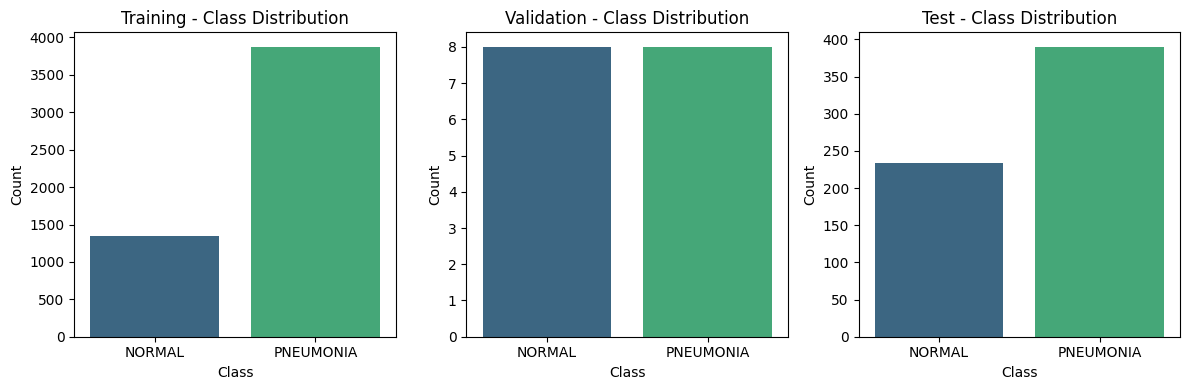

In [56]:
# Data Exploration - Class Distribution with 1x3 subplot
def plot_class_distribution_1x3(train_dataset, val_dataset, test_dataset):
    # Create subplots with 1 row and 3 columns
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    datasets = [(train_dataset, 'Training'), (val_dataset, 'Validation'), (test_dataset, 'Test')]

    for ax, (dataset, dataset_name) in zip(axes, datasets):
        class_counts = Counter([item[1] for item in dataset.imgs])
        class_names = [dataset.classes[i] for i in class_counts.keys()]

        sns.barplot(x=class_names, y=list(class_counts.values()), palette="viridis", ax=ax)
        ax.set_title(f'{dataset_name} - Class Distribution')
        ax.set_xlabel('Class')
        ax.set_ylabel('Count')

    # Adjust layout for better spacing
    plt.tight_layout()
    plt.show()

# Plot class distribution for training, validation, and test datasets in 1x3 plot
plot_class_distribution_1x3(train_dataset, val_dataset, test_dataset)


The training dataset is significantly imbalanced, with the Pneumonia class having many more samples than the Normal class, which may lead to a model that favors Pneumonia predictions. The validation set is extremely small, with only 8 samples per class, making it difficult to obtain reliable validation metrics and increasing the risk of overfitting. The test set also shows some imbalance but is less extreme, with around 400 Pneumonia samples and 250 Normal samples. o resolve these issues, we can consider balancing the training set using oversampling, class weighting, or undersampling and expanding the validation set for more reliable model evaluation.

### 2.5.2 Image Properties<a id='2.5.2_Image'></a>

In [57]:
# Data Exploration - Image Properties and Corrupted Image Handling
def check_image_properties(dataset):
    image_paths = [item[0] for item in dataset.imgs]
    for img_path in image_paths[:5]:  # Check first 5 images as samples
        try:
            with Image.open(img_path) as img:
                print(f"Image: {img_path}, Size: {img.size}, Mode: {img.mode}")
        except UnidentifiedImageError:
            print(f"Corrupted image found at: {img_path}. Skipping this image.")
            continue

check_image_properties(train_dataset)

Image: Data/chest_xray/train/NORMAL/IM-0115-0001.jpeg, Size: (2090, 1858), Mode: L
Image: Data/chest_xray/train/NORMAL/IM-0117-0001.jpeg, Size: (1422, 1152), Mode: L
Image: Data/chest_xray/train/NORMAL/IM-0119-0001.jpeg, Size: (1810, 1434), Mode: L
Image: Data/chest_xray/train/NORMAL/IM-0122-0001.jpeg, Size: (1618, 1279), Mode: L
Image: Data/chest_xray/train/NORMAL/IM-0125-0001.jpeg, Size: (1600, 1125), Mode: L


This code defines a function check_image_properties that inspects the properties (size and mode) of the first 5 images in the given dataset. It also handles corrupted images by catching exceptions, printing a message when a corrupted image is encountered, and skipping over it.

### 2.5.3 Data Visualization<a id='2.5.3_Visualization'></a>

This code defines a function visualize_sample_images that displays a specified number of sample images from each class in the given dataset. It creates a 1-row subplot, selects the specified number of images per class, and displays them without axis labels or ticks, along with class titles.

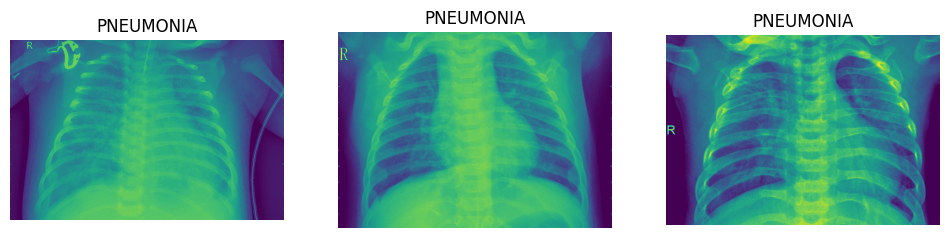

In [58]:
# Data Understanding - Visualize Sample Images
def visualize_sample_images(dataset, num_images=3):
    fig, axes = plt.subplots(1, num_images, figsize=(12, 4))
    class_indices = {cls: [] for cls in range(len(dataset.classes))}

    for i, (img_path, label) in enumerate(dataset.imgs):
        if len(class_indices[label]) < num_images:
            class_indices[label].append(img_path)

    for class_label, img_paths in class_indices.items():
        for i, img_path in enumerate(img_paths[:num_images]):
            with Image.open(img_path) as img:
                axes[i].imshow(img)
                axes[i].set_title(f'{dataset.classes[class_label]}')
                axes[i].axis('off')
    plt.show()

visualize_sample_images(train_dataset)

The result of the code shows three sample images from the Pneumonia class in the training dataset. Each image is a chest X-ray, and the title above each image indicates that all samples belong to the "Pneumonia" class. This suggests that the dataset contains multiple X-rays diagnosed as Pneumonia, and the images are displayed without axis labels to focus on the visual content. It seems no samples from other classes (such as "Normal") were displayed, likely due to the sample selection criteria.

## 2.6 Handling Class Imbalance<a id='2.6_Imbalance'></a>


This code calculates class weights to handle class imbalance in the training dataset. It computes the weights based on the inverse frequency of each class, normalizes the weights, and then converts them into a tensor that can be used in the loss function during model training to give more importance to the minority class.

In [59]:
# Handle Class Imbalance by calculating class weights
train_classes = [item[1] for item in train_dataset.imgs]
class_counts = Counter(train_classes)
total_samples = sum(class_counts.values())
class_weights = {cls: total_samples / count for cls, count in class_counts.items()}

class_weights_normalized = {cls: weight / min(class_weights.values()) for cls, weight in class_weights.items()}
class_weights_tensor = torch.tensor([class_weights_normalized[i] for i in range(len(class_weights_normalized))])

print(f"Class weights for training: {class_weights_tensor}")

Class weights for training: tensor([2.8896, 1.0000])


The result shows that the calculated class weights for training are approximately 2.89 for one class and 1.0 for the other. This indicates that the class with a weight of 2.89 (likely the minority class, such as "Normal") occurs less frequently in the dataset, so it is given more weight to balance the model's focus during training. The class with a weight of 1.0 (likely "Pneumonia") is more frequent and thus receives the baseline weight. These weights help the model treat both classes more equally during training, despite the imbalance.

## 2.7 Create DataLoaders<a id='2.7_DataLoaders'></a>


This code creates DataLoader objects for the training, validation, and test datasets, allowing the data to be loaded in batches of 32 during training and evaluation. The train_loader shuffles the data for better generalization, while the validation and test loaders do not. The code also prints the total number of samples in each dataset.

In [60]:
# Create DataLoaders for batching the data
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print the number of training samples
print(f'Train samples: {len(train_dataset)}')
print(f'Validation samples: {len(val_dataset)}')
print(f'Test samples: {len(test_dataset)}')

Train samples: 5216
Validation samples: 16
Test samples: 624


The result shows that the training dataset contains **5,216 samples**, the validation dataset contains only **16 samples**, and the test dataset has **624 samples**. The large number of training samples is adequate for model training, but the validation set is extremely small, which may lead to unreliable validation metrics. The test set size appears reasonable for evaluating the final model performance.

## 2.8 Create DataFrame<a id='2.8_DataFrame'></a>

This code defines a function create_image_dataframe that generates a pandas DataFrame containing the image paths and labels for a given dataset, along with a column specifying the dataset type (train, validation, or test). It then uses this function to create separate DataFrames for the training, validation, and test datasets for further analysis.

In [61]:
# Create DataFrame for analysis
def create_image_dataframe(dataset, dataset_type):
    image_paths = [item[0] for item in dataset.imgs]
    labels = [item[1] for item in dataset.imgs]

    df = pd.DataFrame({
        'image_path': image_paths,
        'label': labels
    })
    df['dataset_type'] = dataset_type
    return df

# Create DataFrames for train, val, and test datasets
train_df = create_image_dataframe(train_dataset, 'train')
val_df = create_image_dataframe(val_dataset, 'val')
test_df = create_image_dataframe(test_dataset, 'test')

## 2.9 Combine all DataFrames<a id='2.9_Combine'></a>

This code combines the training, validation, and test DataFrames into a single DataFrame (full_df) for easier analysis. It then saves this combined DataFrame as a CSV file named chest_xray_image_data.csv for future reference or exploration.

In [62]:
# Combine all DataFrames into a single DataFrame for easy analysis
full_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

## 2.10 Save the DataFrame<a id='2.10_Save'></a>

This code creates a log file called data_wrangling_log.txt and writes information about the calculated class weights and the class distribution of the training dataset into it. This allows for future reference or auditing of the data wrangling process.

In [65]:
# Save the DataFrames to CSV files for further analysis
train_df.to_csv('chest_xray_image_data_train.csv', index=False)
val_df.to_csv('chest_xray_image_data_val.csv', index=False)
test_df.to_csv('chest_xray_image_data_test.csv', index=False)
full_df.to_csv('chest_xray_image_data_full.csv', index=False)

# Save logs of dataset transformations and class distribution for future reference
log_file = 'data_wrangling_log.txt'
with open(log_file, 'w') as f:
    f.write(f"Class weights for training: {class_weights_tensor.tolist()}\n")
    f.write(f"Training class distribution: {class_counts}\n")

## 2.11 Summary<a id='2.11_Summary'></a>

In this notebook, we explored and prepared the chest X-ray dataset for training a AI model. We performed key data wrangling steps such as image transformations, handling class imbalance, and visualizing class distributions. We observed a significant class imbalance, especially in the training dataset, which was addressed by calculating class weights to improve model performance. Additionally, the validation set was found to be extremely small, which may affect model tuning. Finally, all processed data and class distribution statistics were saved for further analysis, ensuring a reproducible and well-documented workflow.